<a href="https://colab.research.google.com/github/verityw/manipulation-final-project/blob/main/Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://48f442e8bd19.ngrok.io/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:426: DrakeDeprecationWarning: The pose_bundle input port is deprecated.  Use e.g.
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_geometry_query_input_port())
instead. The deprecated code will be removed from Drake on or after 2021-03-01.
  "instead.", date="2021-03-01")


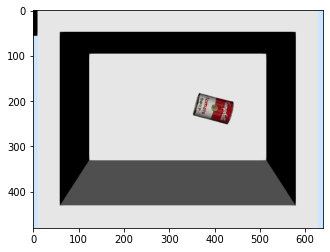

In [39]:
import importlib
import os, sys
from urllib.request import urlretrieve

''' if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
        urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                                "setup_manipulation_colab.py")
        from setup_manipulation_colab import setup_manipulation
        setup_manipulation(manipulation_sha='47a354700b3bc48861400bbe4eb16ad54cf08c05', drake_version='20201101', drake_build='nightly') '''
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201128', drake_build='nightly')

from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# setup ngrok server
server_args = []
if 'google.colab' in sys.modules:
    server_args = ['--ngrok_http_tunnel']

if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from IPython.display import display, HTML
from pydrake.examples.manipulation_station import ManipulationStation

import matplotlib.pyplot as plt, mpld3
if running_as_notebook:
    mpld3.enable_notebook()

import pydrake
from pydrake.all import (
        DiagramBuilder, ConnectMeshcatVisualizer, Simulator, FindResourceOrThrow,
        Parser, MultibodyPlant, RigidTransform, LeafSystem, BasicVector,
        JacobianWrtVariable, RollPitchYaw, SignalLogger, AddTriad,
        PiecewisePolynomial, PiecewiseQuaternionSlerp, RotationMatrix, Solve,
        TrajectorySource
)

from pydrake.multibody import inverse_kinematics
from pydrake.all import SnoptSolver, IpoptSolver
from pydrake.trajectories import PiecewisePolynomial
#########################
# Imports from clutter generation notebook
import numpy as np
from IPython.display import display, HTML
from ipywidgets import Textarea

from pydrake.all import ( 
        AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, 
        DiagramBuilder, RigidTransform, RotationMatrix, Box,        
        CoulombFriction, FindResourceOrThrow, FixedOffsetFrame, 
        GeometryInstance, MeshcatContactVisualizer, Parser, PlanarJoint,    
        JointIndex, Simulator, ProcessModelDirectives, LoadModelDirectives
)

from functools import partial
import open3d as o3d
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

from pydrake.all import (
        ConnectPlanarSceneGraphVisualizer,
        ConnectDrakeVisualizer, DepthCameraProperties, RgbdSensor,
        RandomGenerator, UniformlyRandomRotationMatrix, RollPitchYaw,
        MakeRenderEngineVtk, RenderEngineVtkParams, Role, UnitInertia, set_log_level,
        ColorRenderCamera, DepthRenderCamera, CameraInfo, ClippingRange, RenderCameraCore, DepthRange
)

from ipywidgets import Dropdown, FloatSlider, Layout
from pydrake.all import (
        Sphere, Cylinder, Box, Capsule, Ellipsoid, SpatialInertia)

import pydrake

#from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback
from manipulation.jupyter_widgets import MakeJointSlidersThatPublishOnCallback
from manipulation.meshcat_utils import draw_open3d_point_cloud, draw_points
from manipulation.open3d_utils import create_open3d_point_cloud
from manipulation.mustard_depth_camera_example import MustardExampleSystem
from manipulation.scenarios import AddRgbdSensors
from manipulation.utils import FindResource

set_log_level("warn");

ycb = [("cracker", "003_cracker_box.sdf"), 
                ("sugar", "004_sugar_box.sdf"), 
                ("soup", "005_tomato_soup_can.sdf"), 
                ("mustard", "006_mustard_bottle.sdf"), 
                ("gelatin", "009_gelatin_box.sdf"), 
                ("meat", "010_potted_meat_can.sdf")]

#########################

def setup_manipulation_station():
    builder = DiagramBuilder()
    station = builder.AddSystem(ManipulationStation(time_step=1e-3)) #station.SetupManipulationClassStation() #station.SetupClutterClearingStation()

    plant = station.get_multibody_plant()
    parser = Parser(plant, station.get_mutable_scene_graph())
    parser.AddModelFromFile(FindResourceOrThrow(
                "drake/examples/manipulation_station/models/bin.sdf"))
    plant.WeldFrames(A = plant.world_frame(), 
                                     B = plant.GetFrameByName("bin_base"),
                                X_AB = RigidTransform.Identity())
    table = parser.AddModelFromFile(FindResourceOrThrow("drake/examples/manipulation_station/models/bin.sdf"), "table")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", table), RigidTransform(rpy=RollPitchYaw([np.pi, 0, 0]), p=[-.5, -.6, .2]))

    iiwa_model_file = FindResourceOrThrow(
                        "drake/manipulation/models/iiwa_description/iiwa7/"
                        "iiwa7_no_collision.sdf")
    iiwa = parser.AddModelFromFile(iiwa_model_file, "iiwa")
    X_WI = RigidTransform(rpy=RollPitchYaw([0, 0, np.pi/2]), p=np.array([-0.5, 0, 0])) #.Identity()
    plant.WeldFrames(plant.world_frame(),
                                                 plant.GetFrameByName("iiwa_link_0", iiwa),
                                                 X_WI)
    wsg_model_file = FindResourceOrThrow(
                        "drake/manipulation/models/wsg_50_description/sdf/"
                        "schunk_wsg_50.sdf")
    wsg = parser.AddModelFromFile(wsg_model_file, "gripper")
    X_7G = RigidTransform(rpy=RollPitchYaw([np.pi/2, 0, np.pi/2]), p=[0, 0, 0.114])#RigidTransform.Identity()
    plant.WeldFrames(
                        plant.GetFrameByName("iiwa_link_7", iiwa),
                        plant.GetFrameByName("body", wsg),
                        X_7G)

    station.RegisterIiwaControllerModel(
                        iiwa_model_file, iiwa, plant.world_frame(),
                        plant.GetFrameByName("iiwa_link_0", iiwa), X_WI)
    station.RegisterWsgControllerModel(
                        wsg_model_file, wsg,
                        plant.GetFrameByName("iiwa_link_7", iiwa),
                        plant.GetFrameByName("body", wsg), X_7G)
    
    i = 2
    object_num = i
    sdf = FindResourceOrThrow("drake/manipulation/models/ycb/sdf/" + ycb[object_num][1])
    parser.AddModelFromFile(sdf, f"object{i}")
    
    renderer = "my_renderer"
    station.get_scene_graph().AddRenderer(
        renderer, MakeRenderEngineVtk(RenderEngineVtkParams()))
    
    color_camera = ColorRenderCamera(
    RenderCameraCore("my_renderer", CameraInfo(640, 480, np.pi/4),
                 ClippingRange(0.1, 10.0), RigidTransform()), False)

    depth_camera = DepthRenderCamera(color_camera.core(), DepthRange(0.1, 9.5))

    X_PC = RigidTransform(RollPitchYaw(np.pi, 0, np.pi/2.0), [0, 0, .8])
    station.RegisterRgbdSensor("single_sensor", plant.world_frame(), X_PC, depth_camera)
    station.RegisterRgbdSensor("dual_sensor", plant.world_frame(), X_PC, color_camera, depth_camera)

    station.Finalize()
    
    frames_to_draw = {"gripper": {"body"}}
    meshcat = ConnectMeshcatVisualizer(builder,
                    station.get_scene_graph(),
                    output_port=station.GetOutputPort("pose_bundle"),
                    delete_prefix_on_load=False,
                    frames_to_draw=frames_to_draw,
                    zmq_url=zmq_url)

    diagram = builder.Build()
    
    context = plant.CreateDefaultContext()
    gripper = plant.GetBodyByName("body")
 
    initial_pose = plant.EvalBodyPoseInWorld(context, gripper)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    for body_index in plant.GetFloatingBaseBodies():
        #tf = RigidTransform(rpy=RollPitchYaw([0, 0, 0]), p=[0,0,0.05])
        theta = np.random.rand() * 2 * np.pi
        tf = tf = RigidTransform(
                                        RotationMatrix(pydrake.common.eigen_geometry.AngleAxis_(theta, np.array([0, 0, 1]))),    
                                        [np.random.uniform(-.1,.1), np.random.uniform(-.15, .15), .07])
        plant.SetFreeBodyPose(plant_context, 
                                                plant.get_body(body_index),
                                                tf)

    simulator.set_target_realtime_rate(1.0)
    #simulator.AdvanceTo(0.01)
    simulator.AdvanceTo(1.)
    for body_index in plant.GetFloatingBaseBodies():
        final_pose = plant.GetFreeBodyPose(plant_context, plant.get_body(body_index))
    station_context = station.GetMyContextFromRoot(context)
    color_image = station.GetOutputPort("camera_dual_sensor_rgb_image").Eval(station_context).data    

    return initial_pose, meshcat, final_pose, color_image

# Get initial pose of the gripper by using default context of manip station.
initial_pose, meshcat, final_pose, color_image = setup_manipulation_station()
plt.imshow(color_image)

# Helper function to visualize triad given a rigid transform. 
def visualize_transform(name, transform, prefix='', length=0.15, radius=0.006):
    # Support RigidTransform as well as 4x4 homogeneous matrix.
    if isinstance(transform, RigidTransform):
        transform = transform.GetAsMatrix4()
    AddTriad(meshcat.vis, name=name, prefix=prefix, length=length, radius=0.005, opacity=0.2)
    meshcat.vis[prefix][name].set_transform(transform)

In [40]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision.models
import collections
import math
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=padding,bias=False),
          nn.ReLU(inplace=True),
        )

def fc(in_channels, out_channels):
    return nn.Sequential(
        nn.Linear(in_channels, out_channels),
    )

class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
    def forward(self, x):
        return torch.clamp(x, 0, 2 * np.pi)


class PoseEstimatorNet(nn.Module):
    def __init__(self):
        super(PoseEstimatorNet, self).__init__()
        self.resnet = torchvision.models.resnet18()
        self.initial = conv(4, 3, 1) # in_channels = 4 for RGBAlpha
        self.fc1 = fc(1000, 256)
        self.fc2_position = fc(256, 3)
        self.fc2_rotation = fc(256, 1)
        self.normalize = normalize()
        self.relu = torch.nn.ReLU() 
    def forward(self, x):
        # Convolve to be acceptable size for resnet
        x = self.initial(x)
        # ResNet18
        x = self.resnet(x)
        # Multi-layer perceptron
        x = self.fc1(x)
        x = self.relu(x)
        x_pos = self.fc2_position(x)
        x_rot = self.fc2_rotation(x)
        x_rot = self.normalize(x_rot)

        return x_pos, x_rot


In [41]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
cd /content/gdrive/MyDrive/Subjects/Year\ 2/Fall\ 20/'6.881: Intelligent Robot Manipulation'/'6.881 Final Project'

/content/gdrive/MyDrive/Subjects/Year 2/Fall 20/6.881: Intelligent Robot Manipulation/6.881 Final Project


In [43]:
model = PoseEstimatorNet()
check = os.path.join(os.getcwd(), "checkpoints2", "epoch8loss0.0016039922002199323")
model.load_state_dict(torch.load(check, map_location="cpu"))
model.eval()

PoseEstimatorNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [44]:
color_img = np.transpose(color_image, (2, 0, 1))
tensor_img = torch.unsqueeze(torch.tensor(color_img), 0)  / 255.
pred = model(tensor_img)

In [45]:
print(pred)
t, r = pred[0][0].detach().numpy(), float(pred[1][0])
pose = RigidTransform(rpy = RollPitchYaw(0, 0, r), p=t)
print(pose.translation())
print(pose.rotation().matrix())

(tensor([[-0.0280,  0.0981,  0.0698]], grad_fn=<AddmmBackward>), tensor([[2.8388]], grad_fn=<ClampBackward>))
[-0.02800781  0.09814692  0.06977742]
[[-0.95451266 -0.29817041  0.        ]
 [ 0.29817041 -0.95451266  0.        ]
 [-0.          0.          1.        ]]


In [46]:
print(final_pose.translation())
print(final_pose.rotation().matrix())

[-0.02927531  0.10106839  0.04682716]
[[-9.67295332e-01 -2.53652086e-01 -6.00228003e-04]
 [ 2.53652437e-01 -9.67295238e-01 -6.04059730e-04]
 [-4.27376678e-04 -7.36553452e-04  9.99999637e-01]]


In [47]:
p_WAbove = np.array([0, 0, .5]) # Position above bin. Pre/post-grasp pose.
p_WFinal = np.array([-.5, -.6, .5]) # Position above table

# Interpolate pose for opening doors. 
def InterpolatePoseOpen(t):
    angle_start, angle_end = 0, np.pi/2
    theta = angle_start + (angle_end - angle_start) * t
    p_WG = np.array([np.cos(theta)*.5, np.sin(theta)*-.6, np.sin(theta)*-.2]) + np.array([-.5, 0, .5])
    TEMP = RollPitchYaw(0, np.pi/2 - theta, -theta).ToRotationMatrix()
    R_WG = TEMP.multiply(RollPitchYaw(0, np.pi, 3*np.pi/2).ToRotationMatrix())

    X_WG = RigidTransform(R_WG, p_WG)

    return X_WG

## Interpolate Pose for entry.
def make_gripper_orientation_trajectory():
    traj = PiecewiseQuaternionSlerp()
    traj.Append(0.0, initial_pose.rotation())
    traj.Append(5.0, InterpolatePoseOpen(0.0).rotation())
    return traj 

def make_gripper_position_trajectory():
    traj = PiecewisePolynomial.FirstOrderHold(
            [0.0, 5.0], 
            np.vstack([[initial_pose.translation()],
                                 [InterpolatePoseOpen(0.0).translation()]]).T)
    return traj

entry_traj_rotation = make_gripper_orientation_trajectory()
entry_traj_translation = make_gripper_position_trajectory()

def InterpolatePoseEntry(t):
    return RigidTransform(RotationMatrix(entry_traj_rotation.value(t)), 
                                                entry_traj_translation.value(t))

def GenerateTrajectory(start, end, initialpose, goalpose):
        traj_translation = PiecewisePolynomial.FirstOrderHold(
                [start, end],
                np.vstack([[initialpose.translation()], [goalpose.translation()]]).T
        )
        traj_rotation = PiecewiseQuaternionSlerp()
        traj_rotation.Append(start, initialpose.rotation())
        traj_rotation.Append(end, goalpose.rotation())
        return traj_translation, traj_rotation

def GenerateInterpolation(start, end, initialpose, goalpose):
    '''
    Given start/end times and poses, interpolates between them and creates a function to access the interpolated poses at various times
    '''
    traj_t, traj_r = GenerateTrajectory(start, end, initialpose, goalpose)
    def InterpolatePoseFxn(t):
        return RigidTransform(RotationMatrix(traj_r.value(t)), traj_t.value(t))
    return InterpolatePoseFxn

# Generate interpolation functions
# Initial pose -> elevated pose (to avoid hitting bin)
elev_pose = RigidTransform(initial_pose.rotation(), initial_pose.translation() + np.array([0, .1, .3]))
InterpolatePose_Init_Elev = GenerateInterpolation(0, 1., initial_pose, elev_pose)
# Elevated pose -> pre-grasp pose
p, r = pose.translation(), pose.rotation().matrix() #final_pose.translation(), final_pose.rotation().matrix()
z_axis = r[:, 1].flatten()
y_axis = np.array([0, 0, -1.])
x_axis = np.cross(y_axis, z_axis)
mat = np.vstack([x_axis, y_axis, z_axis]).transpose()
rotmat = RotationMatrix(mat)
translation = np.array([p[0], p[1], elev_pose.translation()[-1]])
pg_pose = RigidTransform(rotmat, translation)
InterpolatePose_Elev_Pg = GenerateInterpolation(1., 2.5, elev_pose, pg_pose)
# Pre-grasp pose -> grab object pose
translation = np.array([p[0], p[1], final_pose.translation()[2] + .05])
grab_pose = RigidTransform(rotmat, translation)
InterpolatePose_Pg_Grab = GenerateInterpolation(2.5, 4, pg_pose, grab_pose)
# Grab object pose -> pre-grasp pose
post_grab_pose = InterpolatePoseOpen(0)
InterpolatePose_Grab_Pg = GenerateInterpolation(6, 7, grab_pose, post_grab_pose)
# Place pose -> move back pose
back_pose = RigidTransform(InterpolatePoseOpen(1).rotation(), InterpolatePoseOpen(1).translation() + np.array([0, 0, .1]))
InterpolatePose_Place_Back = GenerateInterpolation(12, 15, InterpolatePoseOpen(1), back_pose)
# Move back pose -> pre-grasp pose
InterpolatePose_Back_Pg = GenerateInterpolation(13, 15, back_pose, pg_pose)

# Wrapper function for end-effector pose. Total time: 12 seconds.
def InterpolatePose(t):
    if t < 1.:
        return InterpolatePose_Init_Elev(t)
    elif (t >= 1.) and (t < 2.5):
        return InterpolatePose_Elev_Pg(t)
    elif (t >= 2.5) and (t < 4.):
        return InterpolatePose_Pg_Grab(t)
    elif (t >= 4.) and (t < 6.):
        return InterpolatePose_Pg_Grab(4.)
    elif (t >= 6.) and (t < 7.):
        return InterpolatePose_Grab_Pg(t)
    elif (t >= 7.) and (t < 11.):
        return InterpolatePoseOpen((t - 7.) / 4.)
    elif (t >= 11.) and (t < 12):
        return InterpolatePoseOpen(1)
    else: #elif (t >= 12.) and (t < 15.):
        return InterpolatePose_Place_Back(t)
    ''' else:
        return InterpolatePose_Back_Pg(t) '''


# Visualize our end-effector nominal trajectory. 
t_lst = np.linspace(0, 15, 30)
pose_lst = []

visualize_enabled = True

for t in t_lst:
    if visualize_enabled:
        visualize_transform(str(t), InterpolatePose(t))
    pose_lst.append(InterpolatePose(t))

# Create gripper trajectory. 
gripper_t_lst = np.array([0., 5., 6., 11., 12., 15.])
gripper_knots = np.array([0.05, 0.05, 0., 0., 0.05, 0.05]).reshape(1,6)
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

def CreateIiwaControllerPlant():
        """creates plant that includes only the robot and gripper, used for controllers."""
        robot_sdf_path = FindResourceOrThrow(
                "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
        gripper_sdf_path = FindResourceOrThrow(
                "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
        
        sim_timestep = 1e-3
        plant_robot = MultibodyPlant(sim_timestep)
        parser = Parser(plant=plant_robot)
        parser.AddModelFromFile(robot_sdf_path)
        parser.AddModelFromFile(gripper_sdf_path)
        plant_robot.WeldFrames(
                A=plant_robot.world_frame(),
                B=plant_robot.GetFrameByName("iiwa_link_0"),
                X_AB=RigidTransform(rpy=RollPitchYaw([0, 0, np.pi/2]), p=np.array([-0.5, 0, 0]))
        )
        plant_robot.WeldFrames(
                A=plant_robot.GetFrameByName("iiwa_link_7"),
                B=plant_robot.GetFrameByName("body"),
                X_AB=RigidTransform(RollPitchYaw(np.pi/2, 0, np.pi/2), np.array([0, 0, 0.114]))
        )

        plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
        plant_robot.Finalize()

        link_frame_indices = []
        for i in range(8):
                link_frame_indices.append(
                        plant_robot.GetFrameByName("iiwa_link_" + str(i)).index())

        return plant_robot, link_frame_indices

def BuildAndSimulateTrajectory(q_traj, g_traj):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    station = builder.AddSystem(ManipulationStation(time_step=1e-3))
    plant = station.get_multibody_plant()
    parser = Parser(plant, station.get_mutable_scene_graph())
    parser.AddModelFromFile(FindResourceOrThrow(
                "drake/examples/manipulation_station/models/bin.sdf"))
    plant.WeldFrames(A = plant.world_frame(), 
                                     B = plant.GetFrameByName("bin_base"),
                                X_AB = RigidTransform.Identity())
    #bin = parser.AddModelFromFile(FindResource("models/shelves.sdf"))
    #plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("shelves_body", bin), RigidTransform([0.6,0,0.4]))
    table = parser.AddModelFromFile(FindResourceOrThrow("drake/examples/manipulation_station/models/bin.sdf"), "table")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", table), RigidTransform(rpy=RollPitchYaw([np.pi, 0, 0]), p=[-.5, -.6, .2]))

    iiwa_model_file = FindResourceOrThrow(
                        "drake/manipulation/models/iiwa_description/iiwa7/"
                        "iiwa7_no_collision.sdf")
    iiwa = parser.AddModelFromFile(iiwa_model_file, "iiwa")
    X_WI = RigidTransform(rpy=RollPitchYaw([0, 0, np.pi/2]), p=np.array([-0.5, 0, 0])) #.Identity()
    plant.WeldFrames(plant.world_frame(),
                                                 plant.GetFrameByName("iiwa_link_0", iiwa),
                                                 X_WI)
    wsg_model_file = FindResourceOrThrow(
                        "drake/manipulation/models/wsg_50_description/sdf/"
                        "schunk_wsg_50.sdf")
    wsg = parser.AddModelFromFile(wsg_model_file, "gripper")
    X_7G = RigidTransform(rpy=RollPitchYaw([np.pi/2, 0, np.pi/2]), p=[0, 0, 0.114])#RigidTransform.Identity()
    plant.WeldFrames(
                        plant.GetFrameByName("iiwa_link_7", iiwa),
                        plant.GetFrameByName("body", wsg),
                        X_7G)

    station.RegisterIiwaControllerModel(
                        iiwa_model_file, iiwa, plant.world_frame(),
                        plant.GetFrameByName("iiwa_link_0", iiwa), X_WI)
    station.RegisterWsgControllerModel(
                        wsg_model_file, wsg,
                        plant.GetFrameByName("iiwa_link_7", iiwa),
                        plant.GetFrameByName("body", wsg), X_7G)
    
    i = 2
    object_num = i
    sdf = FindResourceOrThrow("drake/manipulation/models/ycb/sdf/" + ycb[object_num][1])
    parser.AddModelFromFile(sdf, f"object{i}")

    station.Finalize()

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

    meshcat = ConnectMeshcatVisualizer(builder,
                    station.get_scene_graph(),
                    output_port=station.GetOutputPort("pose_bundle"),
                    delete_prefix_on_load=True,
                    frames_to_draw={"gripper":{"body"}},
                    zmq_url=zmq_url)
    
    builder.Connect(q_traj_system.get_output_port(),
                                    station.GetInputPort("iiwa_position"))
    builder.Connect(g_traj_system.get_output_port(),
                                    station.GetInputPort("wsg_position"))
 
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyContextFromRoot(context)

    for body_index in plant.GetFloatingBaseBodies():
        tf = final_pose
        plant.SetFreeBodyPose(plant_context, 
                                                plant.get_body(body_index),
                                                tf)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01)

    station_plant = station.get_multibody_plant()
    
    return simulator, station_plant

In [48]:
def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of 
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions 
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array([ 0., 0.6, 0., -1.75, 0., 1., 0., 0., 0.]) # nominal joint for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality 
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
                frameAbar=world_frame, R_AbarA=R_WG, 
                frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
                theta_bound=bounds
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to 
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
                frameA=world_frame, frameB=gripper_frame, p_BQ=np.zeros(3),
                p_AQ_lower=p_WG_lower, p_AQ_upper=p_WG_upper)

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q() # Get variables for MathematicalProgram
        prog = ik.prog() # Get MathematicalProgram

        #### Modify here ###############################
        des_pose = pose_lst[i]
        des_translation = des_pose.translation()
        des_rotation = des_pose.rotation()

        TEMP = q_nominal - q_variables
        prog.AddCost(TEMP.dot(TEMP)) # Joint centering cost

        if i == 0:
                init_guess = q_nominal
        else:
                init_guess = q_knots[-1]
        
        prog.SetInitialGuess(q_variables, init_guess)

        theta_bound = np.pi / 24
        t_bound = np.array([0, 0, .01])

        AddOrientationConstraint(ik, des_rotation, theta_bound)
        AddPositionConstraint(ik, des_translation - t_bound, des_translation + t_bound)

        ################################################
    
        result = Solve(prog)

        if not result.is_success():
            raise RuntimeError
            
        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [49]:
q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://48f442e8bd19.ngrok.io/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:426: DrakeDeprecationWarning: The pose_bundle input port is deprecated.  Use e.g.
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_geometry_query_input_port())
instead. The deprecated code will be removed from Drake on or after 2021-03-01.
  "instead.", date="2021-03-01")


In [50]:
simulator.AdvanceTo(0.1)
# Uncomment and run the simulation to 12 seconds for results.
simulator.AdvanceTo(15.0)